In [2]:
qasm_code = "OPENQASM 2.0;\ninclude \"qelib1.inc\";\nqreg q[3];\ncreg c[3];\nh q[0];\nh q[1];\nh q[2];\ncx q[0],q[2];\nrz(0.2) q[2];\ncx q[0],q[2];\ncx q[1],q[2];\nrz(0.2) q[2];\ncx q[1],q[2];\nrx(0.4) q[0];\nrx(0.4) q[1];\nh q[2];\nmeasure q[0] -> c[0];\nmeasure q[1] -> c[1];\nmeasure q[2] -> c[2];\n"


#"OPENQASM 2.0;\ninclude \"qelib1.inc\";\nqreg q[3];\ncreg c[3];\nh q[0];\nh q[1];\nh q[2];\ncx q[0],q[2];\nrz(0.2) q[2];\ncx q[0],q[2];\ncx q[1],q[2];\nrz(0.2) q[2];\ncx q[1],q[2];\nrx(0.4) q[0];\nrx(0.4) q[1];\nrx(0.4) q[2];\nmeasure q[0] -> c[0];\nmeasure q[1] -> c[1];\nmeasure q[2] -> c[2];"

my_backends = ["", "fake_brisbane", "fake_kyoto"]

shots = 8000

qasm_code

'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[3];\ncreg c[3];\nh q[0];\nh q[1];\nh q[2];\ncx q[0],q[2];\nrz(0.2) q[2];\ncx q[0],q[2];\ncx q[1],q[2];\nrz(0.2) q[2];\ncx q[1],q[2];\nrx(0.4) q[0];\nrx(0.4) q[1];\nh q[2];\nmeasure q[0] -> c[0];\nmeasure q[1] -> c[1];\nmeasure q[2] -> c[2];\n'

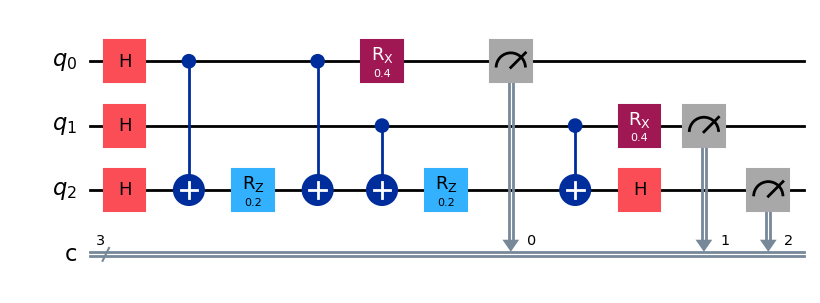

In [5]:
from qiskit import QuantumCircuit

qc = QuantumCircuit.from_qasm_str(qasm_code)
qc.draw(output='mpl')

In [11]:
d = {}

d["qubits"] = qc.num_qubits
d["depth"] = qc.depth()
d["num_gates"] = qc.size()

d["2q_depth"] = qc.depth(filter_function=lambda x: x.operation.num_qubits == 2)

d['num_1q_gates'] = sum(1 for op in qc.data if op.operation.num_qubits == 1)
d['num_2q_gates'] = sum(1 for op in qc.data if op.operation.num_qubits == 2)
d['num_measurements'] = sum(1 for op in qc.data if op.operation.name == 'measure')

d["gates"] = dict(qc.count_ops())

d

{'qubits': 3,
 'depth': 9,
 'num_gates': 15,
 '2q_depth': 4,
 'num_1q_gates': 11,
 'num_2q_gates': 4,
 'num_measurements': 3,
 'gates': {'h': 4, 'cx': 4, 'measure': 3, 'rz': 2, 'rx': 2}}

In [211]:
from qiskit import transpile
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeProviderForBackendV2 as FakeProvider
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit.quantum_info import SparsePauliOp

obs = "ZZX"

res = {}
res_estimates = {}

for backend_name in my_backends:
    print(f"Running on {backend_name}")
    
    
    if backend_name != "":
        backend = FakeProvider().backend(backend_name)
        sim = AerSimulator.from_backend(backend)
    else:
        backend = AerSimulator()
        sim = backend
        
    estimator = Estimator(backend=backend)
    
    observable = SparsePauliOp(obs)
    
    
    transpiled = transpile(qc, backend)
    _res = sim.run(transpiled, shots=shots).result().get_counts() #OSSERVABILI NON PUSHATE SOLO ZZZZ...
    
    pm = generate_preset_pass_manager(optimization_level=0, backend=backend)
    isa_circuit = pm.run(qc)
    isa_observable = observable.apply_layout(isa_circuit.layout)    
    
    _res_estimates = estimator.run([(isa_circuit, isa_observable)]).result()[0].data.evs
    
    print(_res_estimates)
    
    res[backend_name] = _res
    res_estimates[backend_name] = _res_estimates
    
print(res)
print(res_estimates)

Running on 
-0.02001953125
Running on fake_brisbane
0.01416015625
Running on fake_kyoto
-0.01025390625
{'': {'011': 1917, '111': 63, '100': 100, '001': 2002, '000': 1975, '010': 1943}, 'fake_brisbane': {'101': 24, '110': 28, '100': 88, '001': 2045, '000': 1882, '010': 1932, '111': 96, '011': 1905}, 'fake_kyoto': {'100': 1008, '110': 979, '001': 1001, '101': 1041, '000': 993, '010': 1007, '111': 1019, '011': 952}}
{'': array(-0.02001953), 'fake_brisbane': array(0.01416016), 'fake_kyoto': array(-0.01025391)}
